## WIPRO stock price prediction

Wipro (WIT) is a multinational corporation that provides information technology, consultant and business process services. It is one of the leading Big Tech companies.<br>
Today, we will try to predict WIT's stock price using ARIMA and LSTM models. 

We will follow below steps to solve this time series problem:
1. Load the stock data
2. Analyze the stock data
3. ARIMA
<br>&nbsp;3.1. Find 'd'
<br>&nbsp;3.2. Find 'p'
<br>&nbsp;3.3. Find 'q'
<br>&nbsp;3.4. Fit ARIMA model
<br>&nbsp;3.5. Forecast using ARIMA model
4. LSTM
<br>&nbsp;4.1. Create features (lags)
<br>&nbsp;4.2. Split data into train, CV, test 
<br>&nbsp;4.3. Train LSTM model on train data and predict for CV, test
<br>&nbsp;4.4. Plot result




In [363]:
# General
from datetime import datetime, timedelta

# Data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# To download stock data
import yfinance as yf 

# Featurization
from sklearn.preprocessing import MinMaxScaler

# Time series
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

# DL
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

# Perf metrics
from sklearn.metrics import mean_squared_error


#### 1. Load data

In [261]:
end = datetime.now()
start = datetime(end.year-5, end.month, end.day)

wit = yf.download('WIT', start, end)

[*********************100%***********************]  1 of 1 completed


In [262]:
print('Shape of data: {0}'.format(wit.shape))

Shape of data: (1259, 6)


In [263]:
wit.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-21,4.55,4.57,4.51,4.54,4.446118,750100
2018-05-22,4.56,4.66,4.52,4.62,4.524464,1306500
2018-05-23,4.58,4.63,4.50,4.62,4.524464,695200
2018-05-24,4.62,4.63,4.53,4.59,4.495084,518200
2018-05-25,4.61,4.63,4.57,4.60,4.504878,529500


Our data is at day level and excludes weekends.
For each day, we have the opening price (Open), highest price (High), lowest price (Low), Closing price (Close), Adjusted Closing price (Adj Close) and Sales volume (Volume) 

#### 2. Analyzing stock data

In [264]:
wit.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,5.431843,5.480334,5.384964,5.433582,5.366681,1.804145e+06
std,1.702860,1.711156,1.692970,1.701782,1.685447,1.273662e+06
min,2.520000,2.650000,2.520000,2.570000,2.532681,1.163000e+05
25%,4.310000,4.340000,4.275000,4.310000,4.239552,9.310000e+05
50%,5.030000,5.080000,4.980000,5.040000,4.955365,1.474000e+06
75%,6.385000,6.420000,6.300000,6.380000,6.300763,2.346150e+06
max,9.950000,9.960000,9.870000,9.950000,9.826425,1.451150e+07


In [265]:
wit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-05-21 to 2023-05-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


As we can see that the date is index and has correct data type

##### Closing price

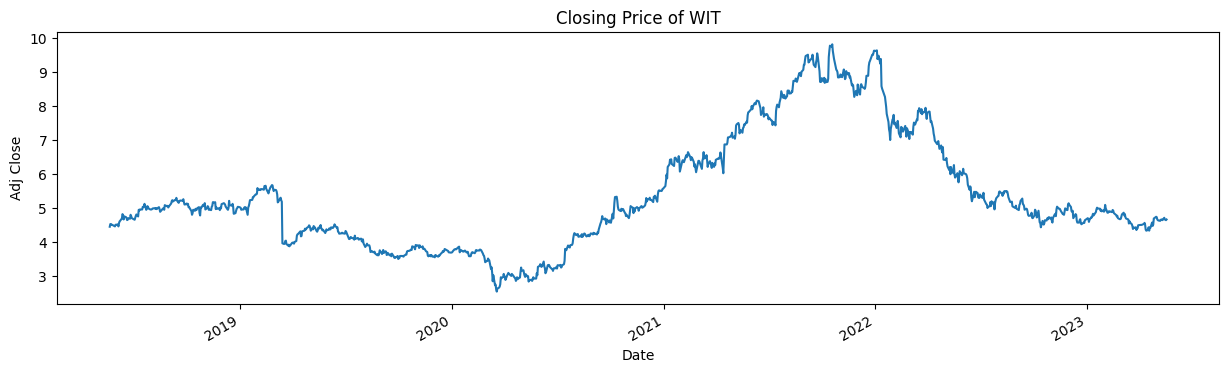

In [266]:
plt.figure(figsize=(15,4))
wit['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel('Date')
plt.title('Closing Price of WIT')
plt.show()

We can see that there are multiple trends that occured during last 5 years. From 2018 to mid-2020, the seems to have declining trend while from mid-2020 to early 2022, the data has upward trend and again a declining trend is observed.

In [267]:
# Copy only 'Adj Close' as 'Price' to working dataframe
data = pd.DataFrame(wit['Adj Close'].copy())
data.columns = ['Price']
data.head()

,Price
Date,
2018-05-21,4.446118
2018-05-22,4.524464
2018-05-23,4.524464
2018-05-24,4.495084
2018-05-25,4.504878


#### 3. ARIMA

ARIMA consists of 3 terms:
1. AR: Autoregression (p)
2. I: Integrated (d)
3. MA: Moving Averages (q)

If we were to apply ARMA model to our time series data, we would have to make sure that our time series is stationary. But 'I' in ARIMA stands for Integrated which makes our time series stationary using a procedure called 'differecing'. We just need to pass the order of differencing as an interger.

Now, our job is to find:
1. Order of differencing (d): This refers to how much differencing is needed to make our time series stationary. We will find this by using 'ndiffs' method from pmdarima package.
2. Order of Auto Regressive (AR) terms (p): This refers to the number of lags to be used as predictors. We will find this using Partial Autocorrelation (PACF) plot.
3. Order of Moving Averages (MA) terms (q):  This refers to the number of lagged forecast errors. We will find this using Autocorrelation (ACF) Plot

##### 3.1. Find 'd'

Check for stationarity

In [268]:
stationary_check = adfuller(data)

# Here adfuller test has below hypothesis
# Ho: The series is non stationary
# Ha: The series is stationary
# Depending on what p-value we will get, we will decide whether to accept or reject null hypothesis

labels = ['ADF Test Statistic', 'p-value', '# Lags', '# Observations']
for k, v in zip(labels, stationary_check):
    print(k+': '+str(v))

if stationary_check[1] <= 0.05:
    print('\nReject Ho. The series is stationary')
else:
    print('\nFail to reject Ho. The series is non stationary')

ADF Test Statistic: -1.1585004161861117
p-value: 0.6911883343848967
# Lags: 0
# Observations: 1258

Fail to reject Ho. The series is non stationary


Lets find 'd' by trying to make the data stationary

Option 1: Lets take log and see if it makes our time series stationary

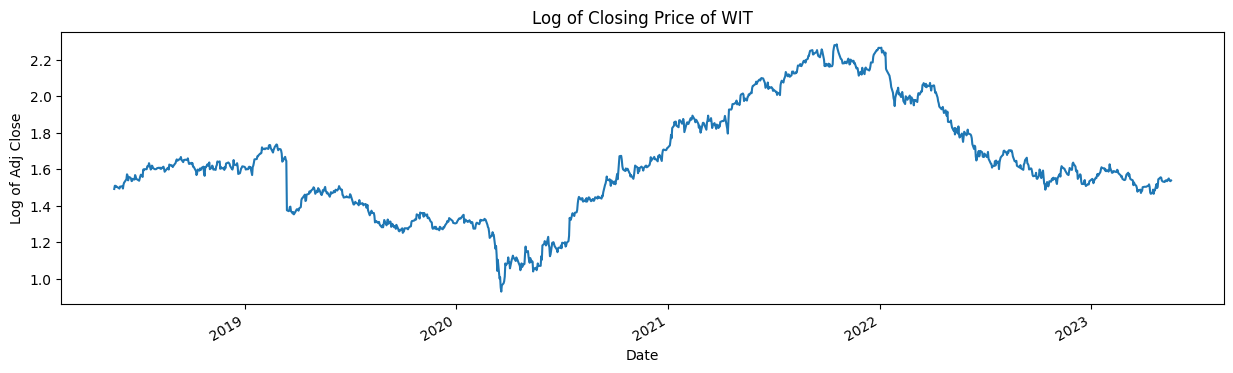

In [269]:
plt.figure(figsize=(15,4))
np.log(data.Price).plot()
plt.ylabel('Log of Adj Close')
plt.xlabel('Date')
plt.title('Log of Closing Price of WIT')
plt.show()

It doesn't look like the log made it stationary. If the log would have made our timeseries stationary, we would use the log of price and simply use ARMA model. Or we will use log of price with d=0 in ARIMA model.

Option 2: Find out the order of differencing by using pmdarima package's ndiffs method

In [270]:
print("The estimated order of differecing is:  {0}".format(ndiffs(data.Price, test="adf")))

The estimated order of differecing is:  1


In [271]:
data_returns = data.copy()
data_returns['Returns'] = data_returns['Price'] - data_returns['Price'].shift(1)
data_returns.head() 

,Price,Returns
Date,,
2018-05-21,4.446118,NaN
2018-05-22,4.524464,0.078345
2018-05-23,4.524464,0.000000
2018-05-24,4.495084,-0.029379
2018-05-25,4.504878,0.009794


In [272]:
data_returns.dropna(inplace=True)
data_returns.head()

,Price,Returns
Date,,
2018-05-22,4.524464,0.078345
2018-05-23,4.524464,0.000000
2018-05-24,4.495084,-0.029379
2018-05-25,4.504878,0.009794
2018-05-29,4.465704,-0.039174


Lets plot the differenced price i.e. returns

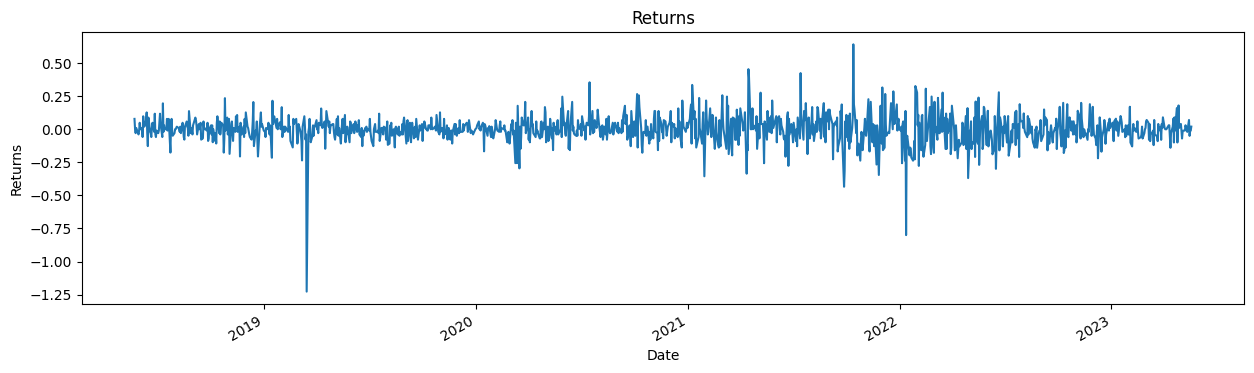

In [273]:
plt.figure(figsize=(15,4))
data_returns['Returns'].plot()
plt.ylabel('Returns')
plt.xlabel('Date')
plt.title('Returns')
plt.show()

Now it looks like our time series has become stationary. Lets check using adfuller test.

In [274]:
# It looks stationary, but lets check using adfuller test as well
stationary_check = adfuller(data_returns.Returns)

# Here adfuller test has below hypothesis
# Ho: The series is non stationary
# Ha: The series is stationary
# Depending on what p-value we will get, we will decide whether to accept or reject null hypothesis

labels = ['ADF Test Statistic', 'p-value', '# Lags', '# Observations']
for k, v in zip(labels, stationary_check):
    print(k+': '+str(v))

if stationary_check[1] <= 0.05:
    print('\nReject Ho. The series is stationary')
else:
    print('\nFail to reject Ho. The series is non stationary')


ADF Test Statistic: -36.255564573043515
p-value: 0.0
# Lags: 0
# Observations: 1257

Reject Ho. The series is stationary


We can confirm that we will use d=1 in our ARIMA model.

##### 3.2. Find 'p'
Order of Auto Regressive (AR) terms i.e. p refers to the number of lags to be used as predictors. We will find this using Partial Autocorrelation Plot (PACF) plot.

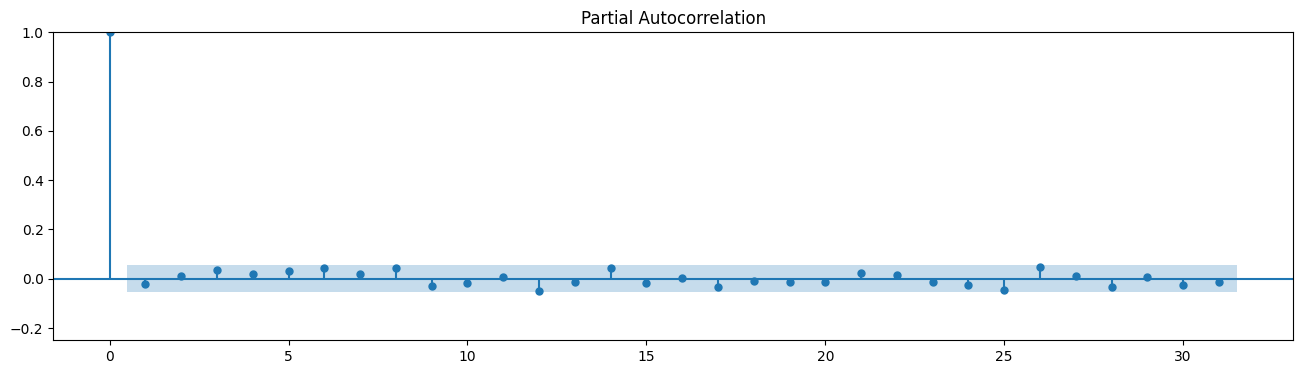

In [275]:
fig, ax1 = plt.subplots(1,1,figsize=(16,4))
sm.graphics.tsa.plot_pacf(data_returns.Returns, ax=ax1);
ax1.set_ylim(-0.25,1)
plt.show()

The highlighted part is confidence interval. We can see that the PACF lag 8 is slightly above the significance line so we can use p=8.


##### 3.3. Find 'q'
Order of Moving Averages (MA) terms (q):  This refers to the number of lagged forecast errors. We will find this using Autocorrelation (ACF) Plot


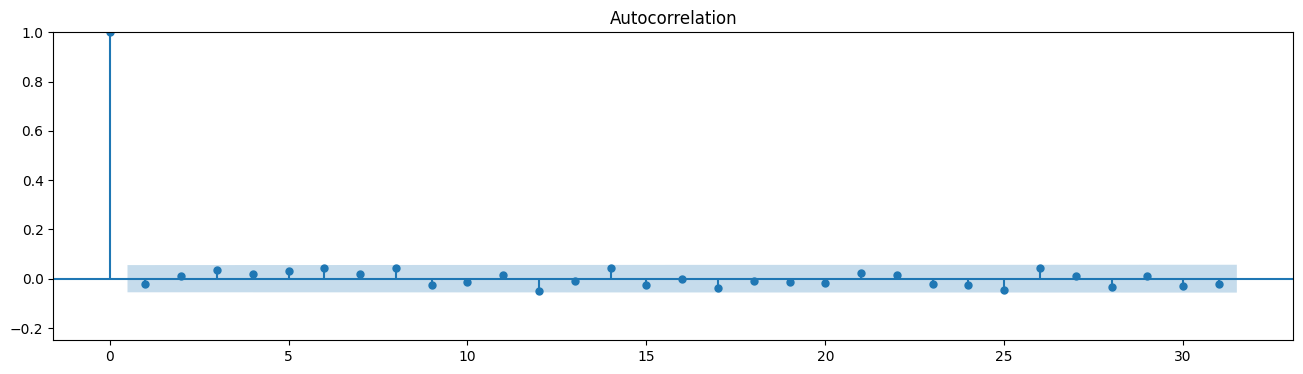

In [276]:
fig, ax1 = plt.subplots(1,1,figsize=(16,4))
sm.graphics.tsa.plot_acf(data_returns.Returns, ax=ax1);
ax1.set_ylim(-0.25,1)
plt.show()

The highlighted part is confidence interval. We can see that the ACF lag 6 is slightly above the significance line so we can use q=6.


##### 3.4. Fit the ARIMA model

In [277]:
model = ARIMA(data, order=(8,1,6))
result = model.fit()

c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\base\model.py:607: Con

In [278]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1259
Model:                 ARIMA(8, 1, 6)   Log Likelihood                1027.436
Date:                Sun, 21 May 2023   AIC                          -2024.872
Time:                        02:47:06   BIC                          -1947.813
Sample:                             0   HQIC                         -1995.912
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.412     -0.867      0.386      -1.164       0.450
ar.L2         -0.4416      0.354     -1.246      0.213      -1.136       0.253
ar.L3          0.1347      0.376      0.359      0.7

Lets check residuals

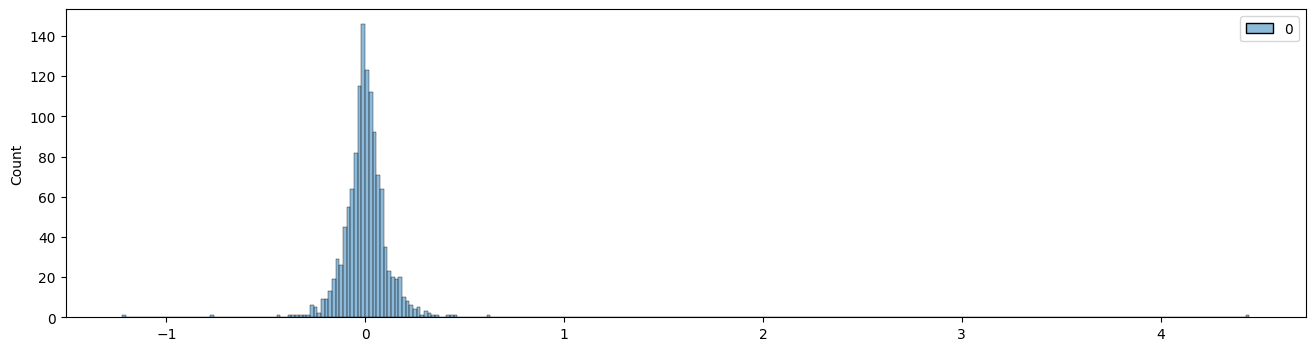

In [279]:
import seaborn as sns
plt.figure(figsize=(16,4))
residuals = pd.DataFrame(result.resid)
sns.histplot(residuals)
plt.show()

Lets check the actual price and fitted price

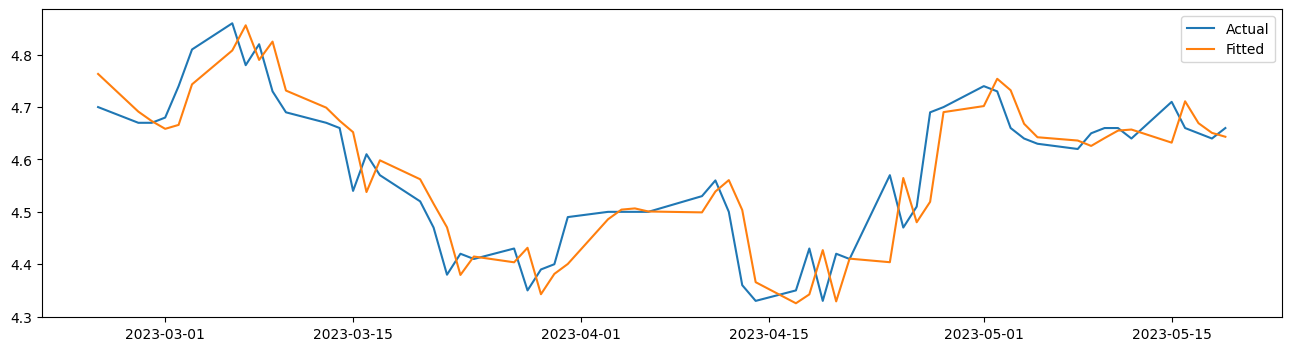

In [280]:
fig = plt.figure(figsize=(16,4))
plt.plot(data[-60:])
plt.plot(result.fittedvalues[-60:])
plt.legend(['Actual', 'Fitted'])
plt.show()

From the above graph of last 60 days, it seems like our ARIMA model has fitted well.

##### 3.5. Forecast using ARIMA model

Split data into train & test

In [281]:
lim = int(len(data) * 0.8)
train = data[:lim]
test = data[lim:]
print("Shape of train: {0}".format(train.shape))
print("Shape of test: {0}".format(test.shape))

Shape of train: (1007, 1)
Shape of test: (252, 1)


Fit ARIMA model with same order on train data

In [282]:
model = ARIMA(train, order=(8,1,6))
result = model.fit()

c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\base\model.py:607: Con

In [283]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1007
Model:                 ARIMA(8, 1, 6)   Log Likelihood                 780.390
Date:                Sun, 21 May 2023   AIC                          -1530.781
Time:                        02:47:21   BIC                          -1457.075
Sample:                             0   HQIC                         -1502.776
                               - 1007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5392      0.428     -1.259      0.208      -1.379       0.300
ar.L2         -0.5018      0.310     -1.620      0.105      -1.109       0.105
ar.L3          0.1900      0.393      0.484      0.629      -0.580       0.960
ar.L4         -0.1521      0.364     -0.418      0.676      -0.866       0.561
ar.L5         -0.3103      0.304     -1.021      0.307      -0.906       0.285
ar.L6         -0.0997      0.240     -0.416      0.677      -0.569       0.370
ar.L7          0.1071      0.035      3.065      0.002       0.039       0.176
ar.L8          0.1000      0.040      2.499      0.012       0.022       0.178
ma.L1          0.5205      0.428      1.216      0.224      -0.319       1.360
ma.L2          0.5255      0.314      1.675      0.094      -0.089       1.140
ma.L3         -0.1547      0.402     -0.385      0.701      -0.943       0.633
ma.L4          0.1809      0.364      0.498      0.619      -0.532       0.893
ma.L5          0.3539      0.316      1.120      0.263      -0.265       0.973
ma.L6          0.1739      0.244      0.713      0.476      -0.304       0.652
sigma2         0.0124      0.000     52.908      0.000       0.012       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13428.27
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now lets forecast 30 steps

In [284]:
steps = 30

fc = result.forecast(steps)

c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Data Science\Projects\2023-05-07 - Stock Price Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [285]:
fc.head()

1007    5.993441
1008    6.001975
1009    5.995140
1010    6.007349
1011    5.996637
Name: predicted_mean, dtype: float64

In [286]:
# Add dates from test to forecast
fc = fc.set_axis(pd.Series(test[:steps].index))

In [287]:
fc.head()

Date
2022-05-19    5.993441
2022-05-20    6.001975
2022-05-23    5.995140
2022-05-24    6.007349
2022-05-25    5.996637
Name: predicted_mean, dtype: float64

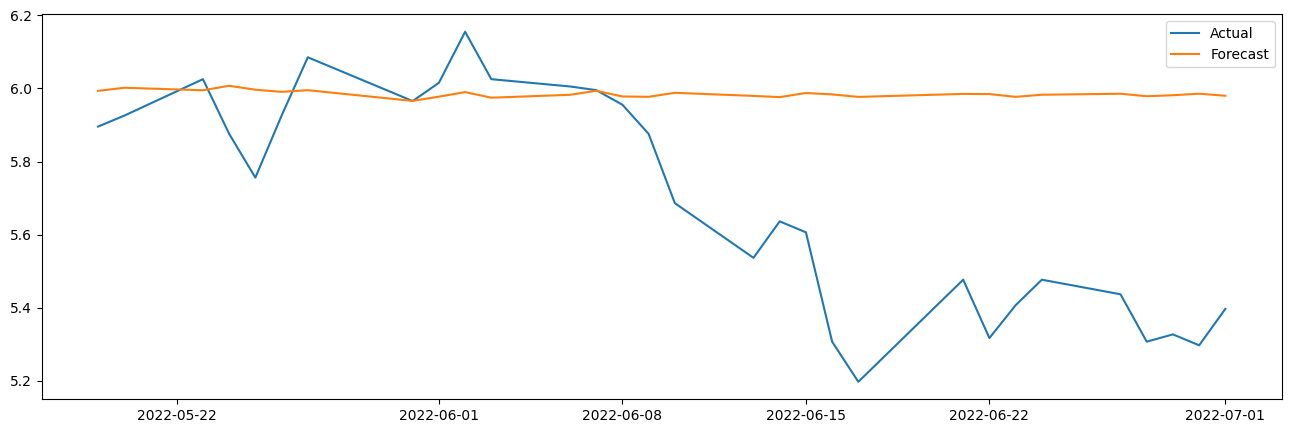

In [288]:
plt.figure(figsize=(16,5))
plt.plot(test[:steps], label='Actual')
plt.plot(fc, label='Forecast')
plt.legend(loc='upper right')
plt.show()

As we can see from above graph, the forecasts are not really optimal. This tells us that the Price series data cannot be fitted properly with just simple looking back at the past values. Another reason is prices are not stationary. The future prices are dependent on many other factors.

#### 4. LSTM

To predict stock price using LSTM, we will convert this timeseries problem to supervised learning problem by creating features. The features we will have are the lag prices for past days. Here we will take n=10 that means we will create 10 features and each feature is lag price from previous n days.

In [311]:
data.head()

,Price
Date,
2018-05-21,4.446118
2018-05-22,4.524464
2018-05-23,4.524464
2018-05-24,4.495084
2018-05-25,4.504878


In [312]:
data = pd.DataFrame(data)

Depending on how many days of lags we want, we will add those many columns. This will give us, for each row/day, past values of the stock.

In [313]:
def to_window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n,0,-1):
        windowed_data[f'Price-{i}'] = data['Price'].shift(i)
    windowed_data['Price'] = data['Price']
    return windowed_data.dropna()

In [314]:
windowed_data = to_window_data(data, n=10)
windowed_data.head()

,Price-10,Price-9,Price-8,Price-7,Price-6,Price-5,Price-4,Price-3,Price-2,Price-1,Price
Date,,,,,,,,,,,
2018-06-05,4.446118,4.524464,4.524464,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912
2018-06-06,4.524464,4.524464,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844
2018-06-07,4.524464,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844,4.602809
2018-06-08,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844,4.602809,4.622396
2018-06-11,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844,4.602809,4.622396,4.690949


Lets split data vertically into Dates, X & y so that we can pass the dependent and independent features separately

In [315]:
windowed_data = windowed_data.reset_index(names=['Date'])
windowed_data.head()

,Date,Price-10,Price-9,Price-8,Price-7,Price-6,Price-5,Price-4,Price-3,Price-2,Price-1,Price
0,2018-06-05,4.446118,4.524464,4.524464,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912
1,2018-06-06,4.524464,4.524464,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844
2,2018-06-07,4.524464,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844,4.602809
3,2018-06-08,4.495084,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844,4.602809,4.622396
4,2018-06-11,4.504878,4.465704,4.455912,4.504878,4.504878,4.514670,4.455912,4.553844,4.602809,4.622396,4.690949


In [316]:
def split_windowed_data(windowed_data):
    df_as_np = windowed_data.to_numpy()
    
    dates = df_as_np[:, 0]
    
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    y = df_as_np[:, -1]

    return dates, X.astype(np.float32), y.astype(np.float32)

In [317]:
print("Shape of windowed data before splitting: {0}".format(windowed_data.shape))
dates, X, y = split_windowed_data(windowed_data)
print("Shape after splitting: ")
print("\tDates: {0}".format(dates.shape))
print("\tX: {0}".format(X.shape))
print("\ty: {0}".format(y.shape)) 

Shape of windowed data before splitting: (1249, 12)
Shape after splitting: 
	Dates: (1249,)
	X: (1249, 10, 1)
	y: (1249,)


Lets split data horizontally into Train, Validation and Test to evaluate model's performance

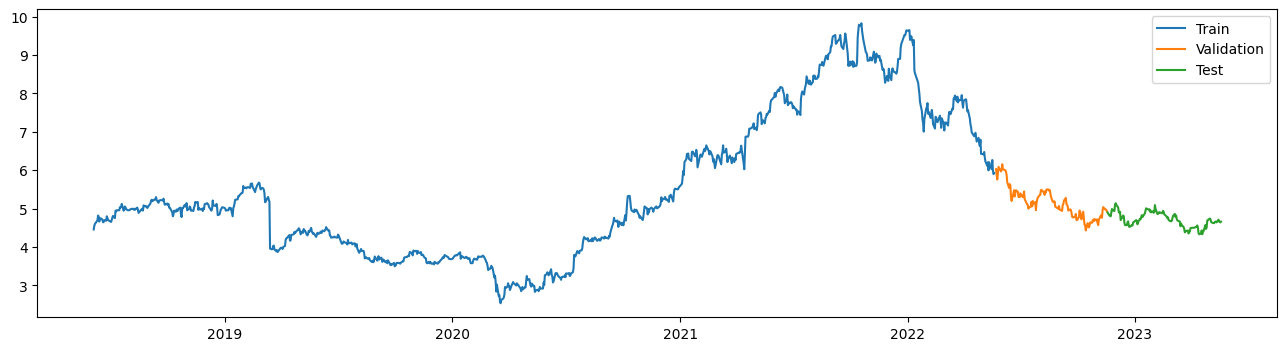

In [318]:
lim_80 = int(len(dates) * .8)
lim_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:lim_80], X[:lim_80], y[:lim_80]
dates_val, X_val, y_val = dates[lim_80:lim_90], X[lim_80:lim_90], y[lim_80:lim_90]
dates_test, X_test, y_test = dates[lim_90:], X[lim_90:], y[lim_90:]

plt.figure(figsize=(16,4))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.show()

Lets fit LSTM model

In [300]:
model = Sequential([layers.Input((10, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 24.8273 - mean_absolute_error: 4.5964 - val_loss: 5.7007 - val_mean_absolute_error: 2.3574
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 4.2927 - mean_absolute_error: 1.6659 - val_loss: 0.1555 - val_mean_absolute_error: 0.3285
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 1.7872 - mean_absolute_error: 1.0319 - val_loss: 0.0538 - val_mean_absolute_error: 0.1808
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1660 - mean_absolute_error: 0.2804 - val_loss: 0.0283 - val_mean_absolute_error: 0.1348
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0462 - mean_absolute_error: 0.1441 - val_loss: 0.0244 - val_mean_absolute_error: 0.1250
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0428 - mean_absolute_error: 0.1430 - val_loss: 0.0287 - val_mean_absolute_error: 0.1342
Epoch 7/100
32/32 [=

32/32 [==============================] - 0s 3ms/step

MSE: 0.01378557551652193


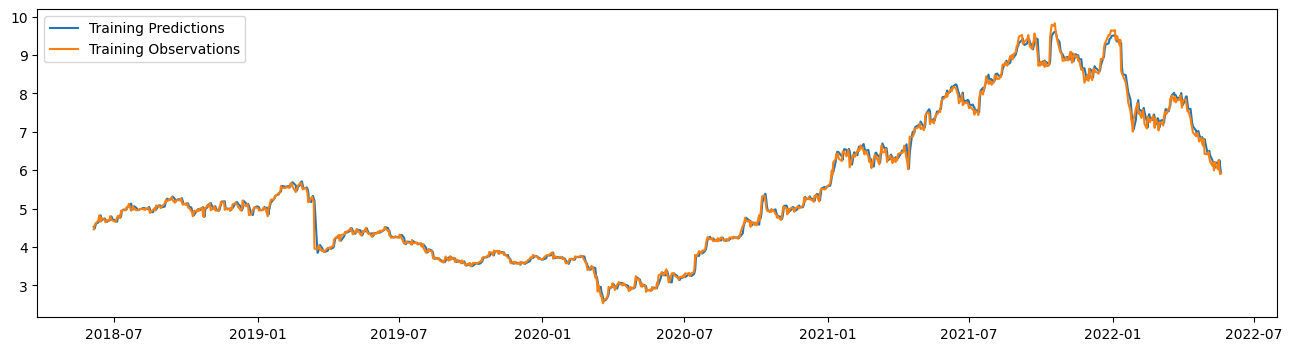

In [319]:
train_predictions = model.predict(X_train).flatten()
print("\nMSE: {0}".format(mean_squared_error(y_train, train_predictions)))

plt.figure(figsize=(16,4))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.show()



4/4 [==============================] - 0s 3ms/step

MSE: 0.011390703730285168


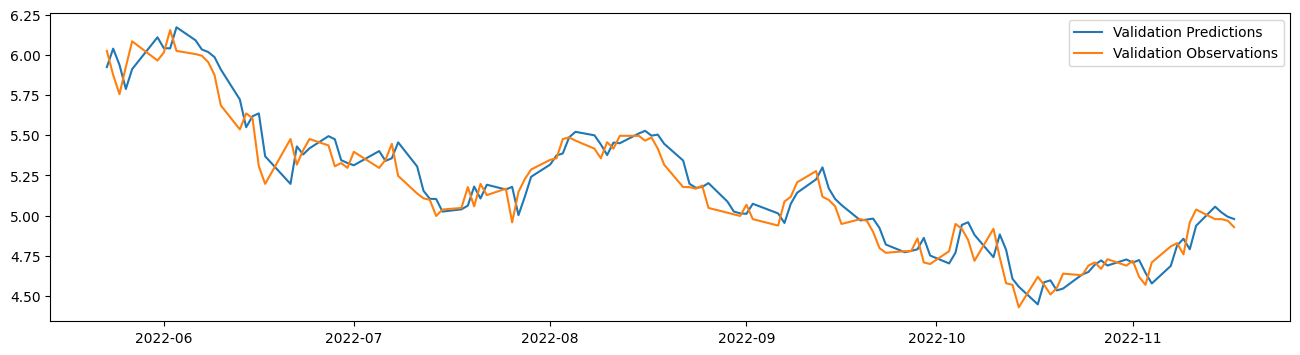

In [320]:
val_predictions = model.predict(X_val).flatten()
print("\nMSE: {0}".format(mean_squared_error(y_val, val_predictions)))

plt.figure(figsize=(16,4))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()

4/4 [==============================] - 0s 3ms/step

MSE: 0.0049990215338766575


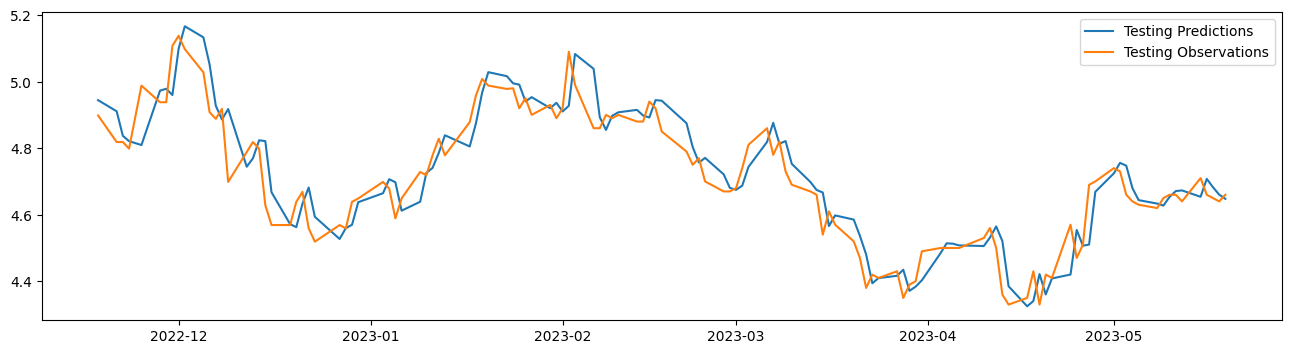

In [321]:
test_predictions = model.predict(X_test).flatten()
print("\nMSE: {0}".format(mean_squared_error(y_test, test_predictions)))

plt.figure(figsize=(16,4))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()

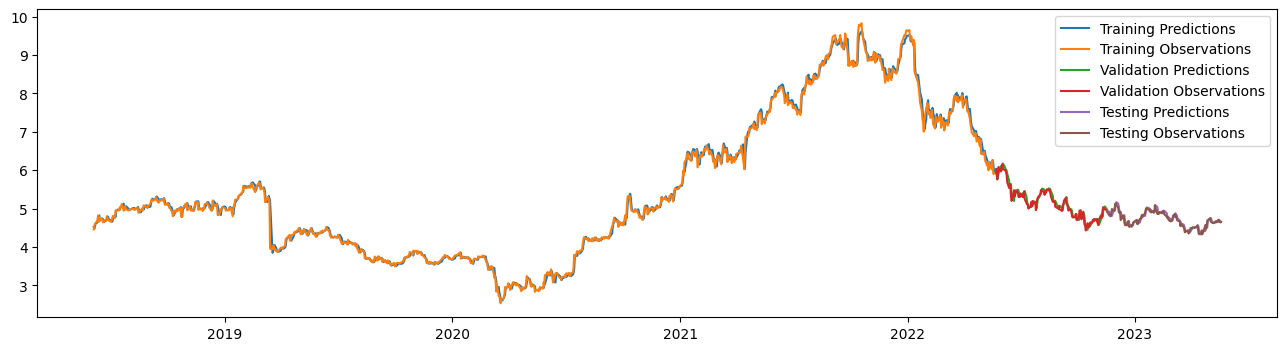

In [322]:
plt.figure(figsize=(16,4))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.show()

##### Forecast
Lets forecast for next 30 days.

In [379]:
forecast_input = test[-10:].values.reshape(1,-1)
forecast_input

array([[4.61999989, 4.6500001 , 4.65999985, 4.65999985, 4.63999987,
        4.71000004, 4.65999985, 4.6500001 , 4.63999987, 4.65999985]])

In [380]:
forecast_input_flattened = list(forecast_input)
forecast_input_flattened = forecast_input_flattened[0].tolist()
forecast_input_flattened

[4.619999885559082,
 4.650000095367432,
 4.659999847412109,
 4.659999847412109,
 4.639999866485596,
 4.710000038146973,
 4.659999847412109,
 4.650000095367432,
 4.639999866485596,
 4.659999847412109]

Now, we need to recursively use the predicted data to predict the next value.
Our logic for this will be:
1. If we are forecasting 1st value, then use actual past data
2. If we are forecasting 2nd onwards values, then take the recently predicted values and if require get the actual values as well 

In [381]:
latest_date = dates_test[-1]
forecasted_dates = []
forecasted_values = []
lags = 10
n_predictions = 30
i = 0

while(i<30):
    if(len(forecast_input_flattened) > 10):
        forecast_input = np.array(forecast_input_flattened[i:])
        forecast_input = forecast_input.reshape(1,-1)
        forecast_input = forecast_input.reshape((1,lags,1))
        yhat = model.predict(forecast_input, verbose=0)
        forecast_input_flattened.extend(yhat[0].tolist())
        forecasted_values.extend(yhat[0].tolist())
        forecasted_dates.append(latest_date + timedelta(days=i+1))
        i = i+1   
    else:
        forecast_input = forecast_input.reshape((1,lags,1))
        yhat = model.predict(forecast_input, verbose=0)
        forecast_input_flattened.extend(yhat[0].tolist())
        forecasted_values.extend(yhat[0].tolist())
        forecasted_dates.append(latest_date + timedelta(days=i+1))
        i = i+1
        
print("Forecast complete!")        

Forecast complete!


Lets plot forecasting together with all other data points

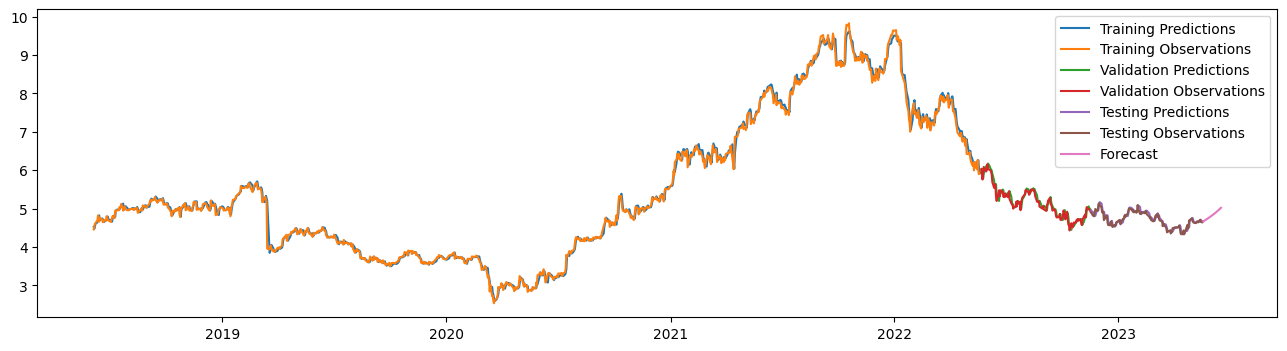

In [415]:
plt.figure(figsize=(16,4))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(forecasted_dates, forecasted_values)

plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Forecast'])
plt.show()

Lets plot only CV, Test & Forecast

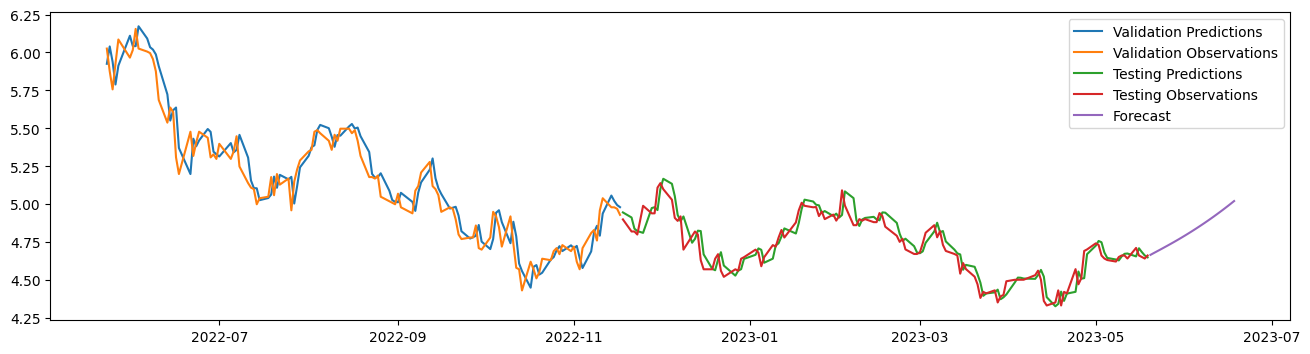

In [416]:
plt.figure(figsize=(16,4))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(forecasted_dates, forecasted_values)

plt.legend(['Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Forecast'])
plt.show()

Looks like the stock is about to go up. TIME TO BUY NOW!